# Load Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable, Dict, List, Optional, Tuple, Union

import mne
from mne.io import read_raw_edf
from mne.io.edf.edf import RawEDF

from idtxl.active_information_storage import ActiveInformationStorage
from idtxl.multivariate_te import MultivariateTE
from idtxl.results import ResultsSingleProcessAnalysis, ResultsNetworkInference
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

In [2]:
dataS = read_raw_edf('../data/s01.edf')
dataH = read_raw_edf('../data/h01.edf')

Extracting EDF parameters from /home/camilojd/Universidad/Primavera_2020/EL7006/dynamicinfo-eeg/data/s01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/camilojd/Universidad/Primavera_2020/EL7006/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
print(dataS.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2004-08-20 12:19:24 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
>


In [4]:
print('Idx | Name Channel')
print('----|-------------')
for i,j in enumerate(dataS.ch_names):
    print('%3d | %s'%(i,j))

Idx | Name Channel
----|-------------
  0 | Fp2
  1 | F8
  2 | T4
  3 | T6
  4 | O2
  5 | Fp1
  6 | F7
  7 | T3
  8 | T5
  9 | O1
 10 | F4
 11 | C4
 12 | P4
 13 | F3
 14 | C3
 15 | P3
 16 | Fz
 17 | Cz
 18 | Pz


# Visualization

Schizophrenic EEG (Raw)


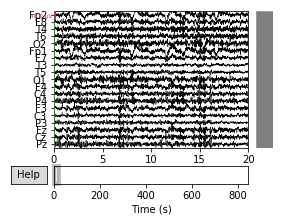

Healthy EEG (Raw)


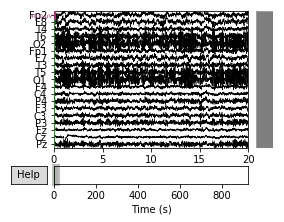

Schizophrenic EEG (Alpha band)
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



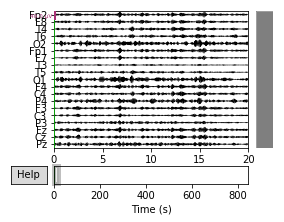

Health EEG (Alpha band)
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



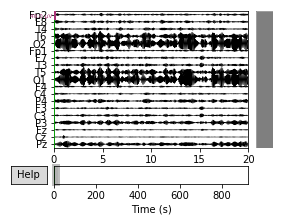

In [17]:
print('Schizophrenic EEG (Raw)')
dataS.plot(duration=20,title="Schizophrenic EEG (Raw)")

print('Healthy EEG (Raw)')
dataH.plot(duration=20,title="Healthy EEG (Raw)")

print('Schizophrenic EEG (Alpha band)')
dataS.plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Schizophrenic EEG (Alpha band)")

print('Health EEG (Alpha band)')
dataH.plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Healthy EEG (Alpha band)")

plt.show()

# Filter data

In [6]:
def filter_eeg(
    raw_edf: RawEDF, 
    filter_band: Optional[str] ='alpha',
    verbose: Optional[bool] = False) -> RawEDF:
    """
    Method description.
    """
    if not filter_band:
        return raw_edf.get_data()
    if filter_band.lower() == 'alpha':
        l_freq = 12.5
        h_freq = 8
    elif filter_band.lower() == 'beta':
        l_freq = 13
        h_freq = 30
    elif filter_band.lower() == 'gamma':
        l_freq = 45
        h_freq = 30
    elif filter_band.lower() == 'delta':
        l_freq = 4
        h_freq = 2
    elif filter_band.lower() == 'theta':
        l_freq = 7.5
        h_freq = 4.5
    else:
        return raw_edf.get_data()
    return mne.filter.filter_data(raw_edf.get_data(), raw_edf.info['sfreq'],
                                  l_freq=l_freq, 
                                  h_freq=h_freq,
                                  method='iir',
                                  iir_params=dict(order=2, ftype='butter'),
                                  verbose=verbose
                                 )

In [7]:
def filter_data(
    raw_edf: RawEDF, 
    time: Optional[int] = 5, 
    filter_band: Optional[str] = None) -> Dict:
    """
    Return data filtered by band.
    """
    n = int(raw_edf.info['sfreq']*time)
    tt = np.linspace(0, time, n)
    data_filtered = filter_eeg(raw_edf, filter_band)
    data_filtered_dict = {
        "data_filtered": data_filtered,
        "tt": tt,
        "n": n
    }
    return data_filtered_dict

def plot_channel(
    raw_edf: RawEDF, 
    n_channel: int, 
    time: Optional[int] = 5, 
    filter_band: Optional[str] = None):
    """
    Plot by channel.
    """
    data_dict = filter_data(raw_edf, time, filter_band)
    data_filtered, tt, n = data_dict["data_filtered"], data_dict["tt"], data_dict["n"]
    # Plotting
    plt.figure(figsize=(10,4))
    plt.plot(tt, raw_edf.get_data()[n_channel,:n], label='Original')
    plt.plot(tt, data_filtered[n_channel,:n], label='Filtered (%s band)' % (filter_band) if filter_band else "Signal")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.title('Channel %s' % (raw_edf.ch_names[n_channel]))

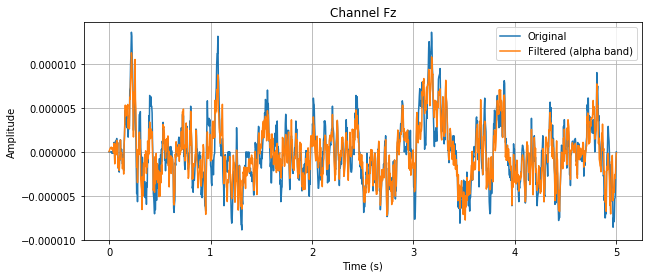

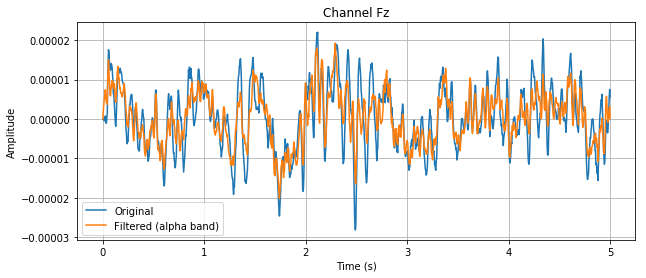

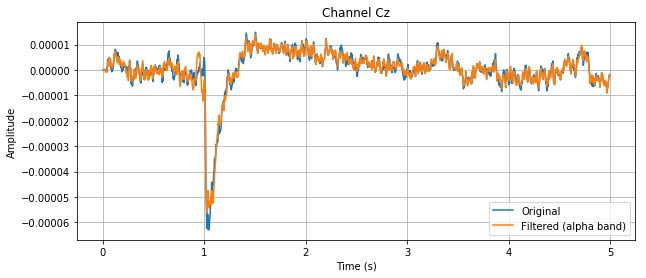

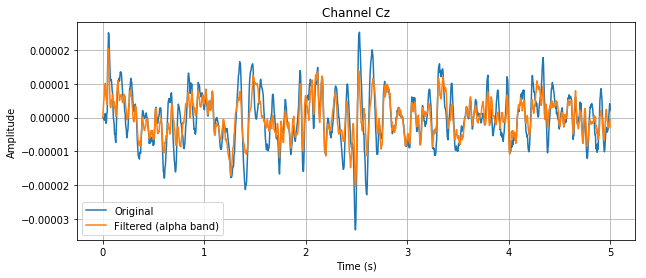

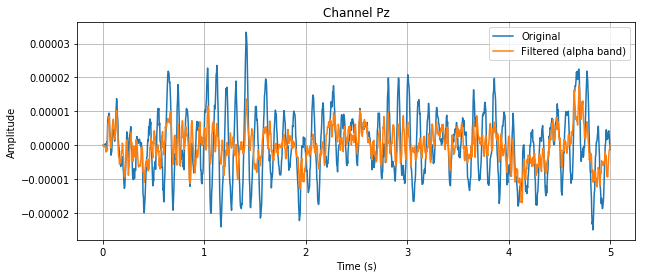

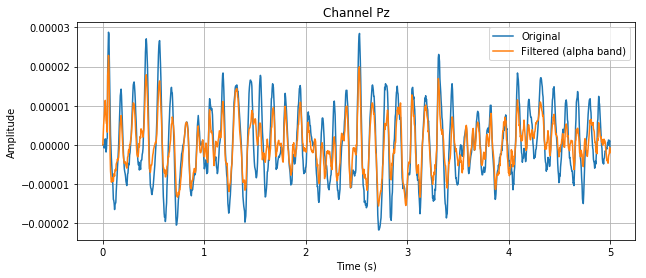

In [8]:
plot_channel(dataH, n_channel=16, filter_band="alpha")
plot_channel(dataS, n_channel=16, filter_band="alpha")

plot_channel(dataH, n_channel=17, filter_band="alpha")
plot_channel(dataS, n_channel=17, filter_band="alpha")

plot_channel(dataH, n_channel=18, filter_band="alpha")
plot_channel(dataS, n_channel=18, filter_band="alpha")

# Network analyser

In [18]:
def analyse_network_by_metric(
    raw_edf: RawEDF, 
    channels: Union[int, List[int]],
    metric: str, 
    time: Optional[int] = 5, 
    filter_band: Optional[str] = 'alpha', 
    **settings: Optional[Dict[str, float]]) -> Union[ResultsSingleProcessAnalysis, ResultsNetworkInference]:
    """
    Analyse nentwork for metrics calculation.
    
    """
    # Configure settings
    if not settings:
        settings = {
                'cmi_estimator':  'JidtKraskovCMI', #JidtGaussianCMI
                'n_perm_max_stat': 11,
                'n_perm_min_stat': 11,
                'alpha_max_stat': 0.1,
                'n_perm_omnibus': 11,
                'alpha_omnibus': 0.1,
                'n_perm_max_seq': 11,
                'alpha_max_seq': 0.1, 
                'alpha_min_stat': 0.1
            }
        if metric == "AIS":
            settings.update({
                'max_lag': 5,
                'local_values':True,
            })
        elif metric == "TE":
            settings.update({
                'max_lag_sources': 3,
                'min_lag_sources': 1
            })
        else:
            raise Exception('Metric parameter must be AIS or TE')
    # Filter data
    data_filtered_dict = filter_data(raw_edf, time, filter_band)
    data_filtered, tt, n = data_filtered_dict["data_filtered"], data_filtered_dict["tt"], data_filtered_dict["n"]
    # Network creation
    if metric == "AIS":
        data = Data(data=data_filtered[channels,:n].reshape(1, -1), dim_order='ps') 
        network_analysis = ActiveInformationStorage()
    elif metric == "TE":
        data = Data(data=data_filtered[channels,:n].reshape(len(channels), n), dim_order='ps') 
        #data = Data(data=data_filtered[:channels,:n].reshape(channels, n), dim_order='ps') 
        network_analysis = MultivariateTE()
    else:
        raise Exception('Metric parameter must be AIS or TE')
    # Return analysis and data filtered
    return network_analysis.analyse_network(settings=settings, data=data), data_filtered_dict

# Active Information Storage (AIS)

Adding data with properties: 1 processes, 1250 samples, 1 replications
overwriting existing data

---------------------------- (1) include candidates


---------------------------- (2) prune source candidates

---------------------------- (3) final statistics


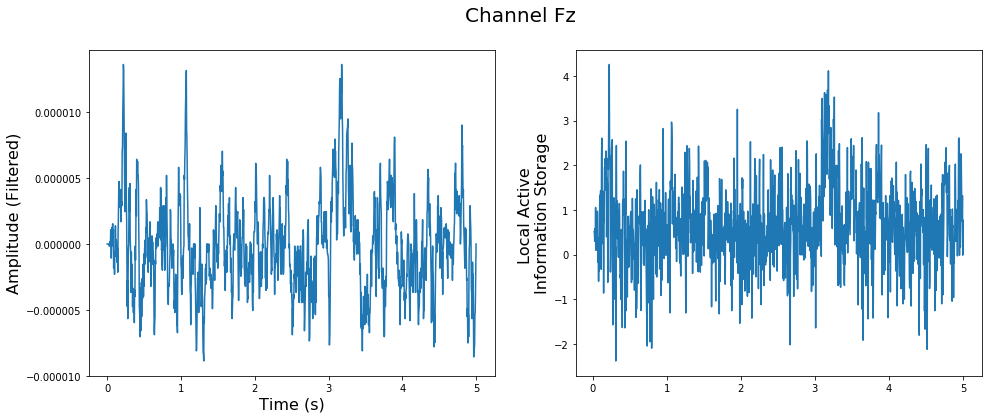

Adding data with properties: 1 processes, 1250 samples, 1 replications
overwriting existing data

---------------------------- (1) include candidates


---------------------------- (2) prune source candidates

---------------------------- (3) final statistics


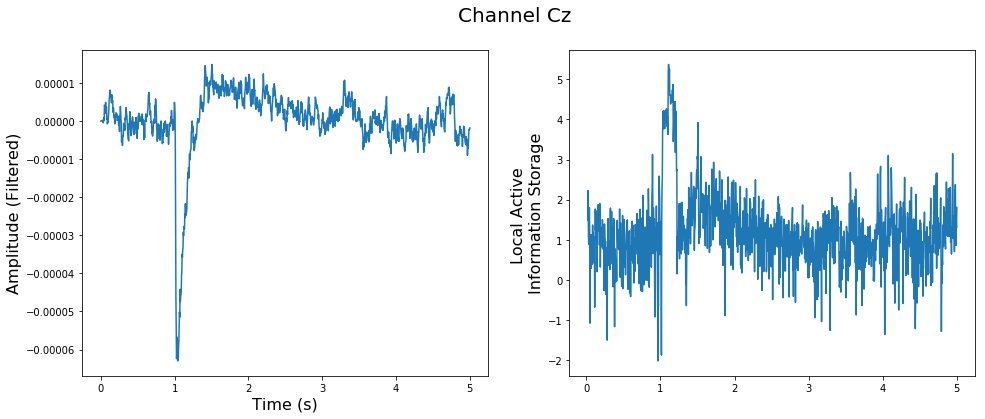

Adding data with properties: 1 processes, 1250 samples, 1 replications
overwriting existing data

---------------------------- (1) include candidates


---------------------------- (2) prune source candidates

---------------------------- (3) final statistics


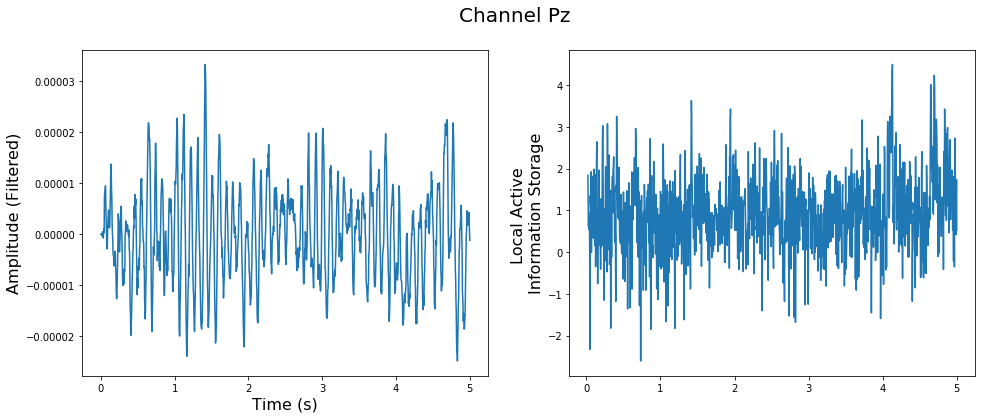

In [10]:
# Setting for AIS calculation 
settings = {
     'cmi_estimator':  'JidtKraskovCMI',
     'max_lag': 5,
     'local_values':True,
     'n_perm_max_stat': 11,
     'n_perm_min_stat': 11,
     'alpha_max_stat': 0.1,
     'n_perm_omnibus': 11,
     'alpha_omnibus': 0.1,
     'n_perm_max_seq': 11,
     'alpha_max_seq': 0.1, 
     'alpha_min_stat': 0.1,
     'verbose': False
}

channels =  [16, 17, 18]
raw_edf = dataH

# Plotting for Fz, Cz and Pz
for n_channel in channels:
    # Calculating AIS
    net_analysis, data_filtered = analyse_network_by_metric(raw_edf, n_channel, "AIS", time=5, filter_band='alpha', **settings)
    n, tt = data_filtered["n"], data_filtered["tt"]
    
    # Plotting
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    ax[0].plot(tt, raw_edf.get_data()[n_channel,:n], label='Original')
    ax[0].set_xlabel('Time (s)', fontsize=16)
    ax[0].set_ylabel('Amplitude (Filtered)', fontsize=16)
    ax[1].plot(tt[net_analysis.settings['max_lag']:], net_analysis.get_single_process(0)['ais'][0])
    ax[1].set_ylabel('Local Active \nInformation Storage', fontsize=16)
    plt.suptitle('Channel %s'%(raw_edf.ch_names[n_channel]), fontsize=20)
    plt.show()

# Transfer Entropy (TE)

In [21]:
settings = {
    'cmi_estimator': 'JidtGaussianCMI',
    'max_lag_sources': 3,
    'min_lag_sources': 1,       
    'n_perm_max_stat': 11,
    'n_perm_min_stat': 11,
    'alpha_max_stat': 0.1,
    'n_perm_omnibus': 11,
    'alpha_omnibus': 0.1,
    'n_perm_max_seq': 11,
    'alpha_max_seq': 0.1, 
    'alpha_min_stat': 0.1,
    'verbose': False
}

raw_edf = dataH

channels =  [16, 17, 18]

# Calculating TE
net_analysis, data_filtered = analyse_network_by_metric(raw_edf, channels, "TE", time=5, filter_band='alpha', **settings)
n, tt = data_filtered["n"], data_filtered["tt"]

Adding data with properties: 3 processes, 1250 samples, 1 replications
overwriting existing data

---------------------------- (1) include target candidates


---------------------------- (2) include source candidates

---------------------------- (3) prune source candidate

---------------------------- (4) final statistics

---------------------------- (1) include target candidates


---------------------------- (2) include source candidates

---------------------------- (3) prune source candidate

---------------------------- (4) final statistics

---------------------------- (1) include target candidates


---------------------------- (2) include source candidates

---------------------------- (3) prune source candidate

---------------------------- (4) final statistics


	0 -> 1, max_te_lag: 1
	0 -> 2, max_te_lag: 1
	1 -> 0, max_te_lag: 1
	2 -> 0, max_te_lag: 1
	2 -> 1, max_te_lag: 1


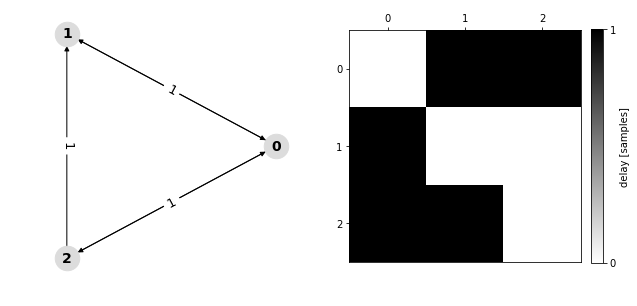

In [22]:
# Plotting
net_analysis.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=net_analysis, weights='max_te_lag', fdr=False)

plt.show()